In [1]:
import matplotlib.pyplot as plt
import sys

In [25]:
def find_matches_and_compress(data):
    """
    Scans the numeric data for repeated sequences (length >= 3).
    Returns a list of 'Sequence' objects: (literals, offset, match_length)
    """
    window_size = 128  # Look back distance
    min_match_len = 3  # Minimum length to consider a match
    
    sequences = []
    hash_table = {} # Maps a 3-number tuple -> index
    
    i = 0
    literal_start = 0
    n = len(data)
    
    while i < n:
        if i + 3 > n:
            i += 1
            continue
            
        key = tuple(data[i:i+3])

        print(f"\nChecking key at index {i}: {key}")

        # Check match
        if key in hash_table:
            match_pos = hash_table[key]
            print(f"  -> Match FOUND for key {key} at previous index {match_pos}")

            if (i - match_pos) < window_size:
                print("  -> Match is within window. Extending match...")

                match_len = 0
                while (i + match_len < n) and \
                      (data[i + match_len] == data[match_pos + match_len]):
                    match_len += 1

                print(f"  -> Match length = {match_len}, Offset = {i - match_pos}")

                literals = data[literal_start : i]
                offset = i - match_pos
                
                sequences.append({
                    'literals': literals,
                    'match_len': match_len,
                    'offset': offset
                })

                # Update hash table for all skipped positions
                for k in range(match_len):
                    if i + k + 3 <= n:
                        h_key = tuple(data[i+k : i+k+3])
                        hash_table[h_key] = i + k
                        print(f"    Hash Update: {h_key} added at position {i+k}")

                i += match_len
                literal_start = i
                continue

        # No match found
        hash_table[key] = i
        print(f"  -> No match. Hash Insert: {key} added at index {i}")

        i += 1

    if literal_start < n:
        sequences.append({
            'literals': data[literal_start:],
            'match_len': 0,
            'offset': 0
        })

    print(" FINAL HASH TABLE CONTENTS")
    for k, v in hash_table.items():
        print(f"{k} -> {v}")

    return sequences

In [26]:
def decompress_sequences(sequences):
    output = []
    
    for seq in sequences:
        output.extend(seq['literals'])
        
        if seq['match_len'] > 0:
            start_index = len(output) - seq['offset']
            for k in range(seq['match_len']):
                val = output[start_index + k]
                output.append(val)
                
    return output

In [27]:
def calculate_compressed_size(sequences):
    total_bytes = 0
    for seq in sequences:
        total_bytes += 1 + len(seq['literals'])
        total_bytes += 1 + 1
    return total_bytes

Enter numeric sensor readings separated by spaces:


>>  1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 6 7 8 9 6 7 8 9



Checking key at index 0: (1, 2, 3)
  -> No match. Hash Insert: (1, 2, 3) added at index 0

Checking key at index 1: (2, 3, 4)
  -> No match. Hash Insert: (2, 3, 4) added at index 1

Checking key at index 2: (3, 4, 5)
  -> No match. Hash Insert: (3, 4, 5) added at index 2

Checking key at index 3: (4, 5, 1)
  -> No match. Hash Insert: (4, 5, 1) added at index 3

Checking key at index 4: (5, 1, 2)
  -> No match. Hash Insert: (5, 1, 2) added at index 4

Checking key at index 5: (1, 2, 3)
  -> Match FOUND for key (1, 2, 3) at previous index 0
  -> Match is within window. Extending match...
  -> Match length = 10, Offset = 5
    Hash Update: (1, 2, 3) added at position 5
    Hash Update: (2, 3, 4) added at position 6
    Hash Update: (3, 4, 5) added at position 7
    Hash Update: (4, 5, 1) added at position 8
    Hash Update: (5, 1, 2) added at position 9
    Hash Update: (1, 2, 3) added at position 10
    Hash Update: (2, 3, 4) added at position 11
    Hash Update: (3, 4, 5) added at posi

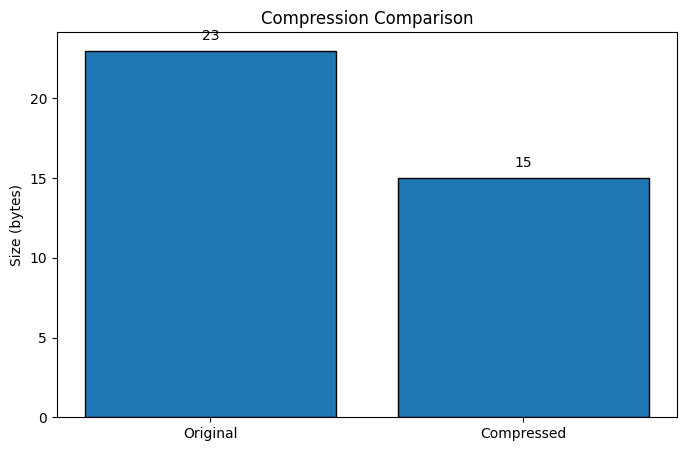

In [28]:
def main():
    print("Enter numeric sensor readings separated by spaces:")
    try:
        user_input = input(">> ")
        data = [int(x) for x in user_input.strip().split()]
        
    except ValueError:
        print("Invalid input. Please enter numbers only.")
        return

    sequences = find_matches_and_compress(data)
    
    decompressed_data = decompress_sequences(sequences)
    
    original_size = len(data)
    compressed_size = calculate_compressed_size(sequences)
    ratio = original_size / compressed_size if compressed_size > 0 else 0

    print("\nRESULTS")
    print(f"Original Sensor Sequence: {' '.join(map(str, data))}")
    
    rep_str_parts = []
    for s in sequences:
        lit_str = str(s['literals'])
        if s['match_len'] > 0:
            rep_str_parts.append(f"[Lit:{lit_str}, MatchLen:{s['match_len']}, Off:{s['offset']}]")
        else:
            rep_str_parts.append(f"[Lit:{lit_str}]")

    print(f"Compressed Representation: {' -> '.join(rep_str_parts)}")
    print(f"Decompressed Output: {' '.join(map(str, decompressed_data))}")
    print(f"Original Bytes: {original_size}")
    print(f"Compressed Bytes: {compressed_size}")
    print(f"Compression Ratio: {ratio:.2f}")
    
    plt.figure(figsize=(8, 5))
    labels = ['Original', 'Compressed']
    values = [original_size, compressed_size]
    bars = plt.bar(labels, values, edgecolor='black')
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x()+bar.get_width()/2, yval + 0.5, round(yval,1),
                 ha='center', va='bottom')
        
    plt.ylabel('Size (bytes)')
    plt.title('Compression Comparison')
    plt.show()

if __name__ == "__main__":
    main()